In [1]:
import numpy as np
import matplotlib.gridspec as grs
import matplotlib.pyplot as plt
from brian2 import defaultclock, nA, pA, us, ms, second, SpikeMonitor, StateMonitor
from teili.core.groups import Neurons, Connections
from teili.models.neuron_models import DPI
from teili.models.synapse_models import DPISyn
from spiking_radio_reservoir import setup_hennequin_connectivity, setup_generator, setup_reservoir_layer, init_network
from utils.reservoir import getTauCurrent
from utils.modulator import AsynchronousDeltaModulator, modulate
from utils.channel import send
from utils.plotting import plot_sample_with_labels

In [2]:
np.random.seed(42)

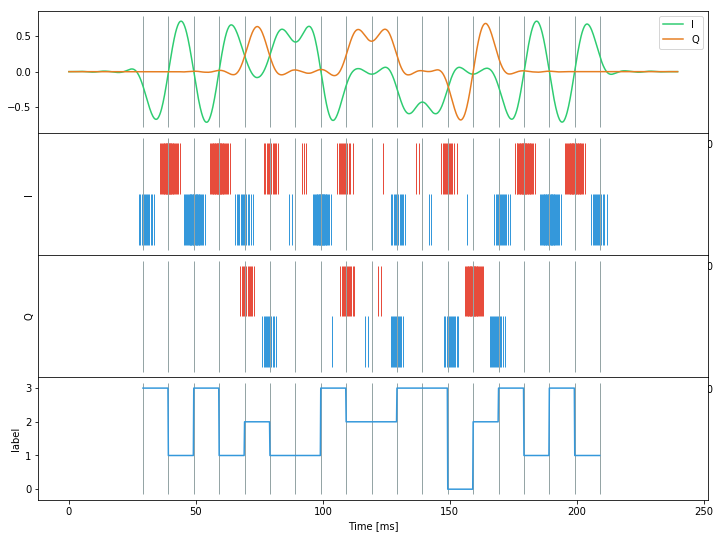

In [19]:
input_string = "neuro"
time_sample, sample, time_labels, labels, bins = send(input_string, m=4)
settings = {
    'thrup': 0.05,
    'thrdn': 0.05,
    'resampling_factor': 100,
    'stretch_factor': 10,
    'pause': 200
}
modulators = [
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
]
indices, times, time_stim, signal = modulate(modulators[0], modulators[1], time_sample, sample, \
                                             resampling_factor=settings['resampling_factor'], stretch_factor=settings['stretch_factor'])
time_labels = time_labels*settings['stretch_factor']
bins = bins*settings['stretch_factor']
plot_sample_with_labels(signal, time_stim, indices, times, labels, time_labels, bins, figsize=(12, 9))

In [4]:
diff = np.diff(bins)
print("Average time length of a baseband symbol: {:.2f}ms".format(np.mean(diff)*1e3))

Average time length of a baseband symbol: 10.00ms


In [5]:
stop = round(bins[-1], ndigits=3)+0.020
indices = np.append(indices, 4)
times = np.append(times, stop)*second

In [6]:
stimulation = (len(time_sample)*settings['stretch_factor']/1e3)*ms

In [7]:
components = {'generator': None, 'layers': {}, 'synapsis': {}, 'monitors': {}}
components = setup_generator(components)

In [8]:
params = {
    'gen_labels': ['I.up', 'I.dn', 'Q.up', 'Q.dn'],
    'wInp': 100,
    'pGI': 0.6,
    'pIR': 0.1,
    'pE_local': 0.5,
    'pI_local': 1.0,
    'k': 3,
    'DoC': 0.2,
    'loc_wGen': 110,
    'scale_wGen': 10,
    'loc_wResE': 0,
    'scale_wResE': 0,
    'loc_wResI': 0,
    'scale_wResI': 0,
    'Ngen': 4,
    'Ninp': 25,
    'N': 200,
    'Ngx': 10,
    'Ngy': 10,
    'currents': {
        'gInp': {
            'Iahp': 0.5*pA,
            'Itau': getTauCurrent(2*ms),
            'Ispkthr': 0.2*nA
        },
        'gRes': {
            'Iahp': 0.5*pA,
            'Itau': getTauCurrent(5*ms)
        },
        'sInpRes': {
            'Ie_tau': getTauCurrent(5*ms)
        },
        'sResRes': {
            'Ie_tau': (getTauCurrent(20*ms), getTauCurrent(5*ms)),
            'Ii_tau': (getTauCurrent(20*ms), getTauCurrent(5*ms))
        }
    },
}

In [9]:
Cgen = [[], []]
for m in range(params['Ngen']):
    for n in range(params['Ninp']):
        r = np.random.uniform()
        if r<params['pGI']:
            Cgen[0].append(m)
            Cgen[1].append(n)
Wgen = np.random.normal(loc=params['loc_wGen'], scale=params['scale_wGen'], size=len(Cgen[0]))

In [10]:
Cinp = [[], []]
M = params['Ngx']*params['Ngy']
Cinp[0] = np.arange(params['Ninp'])
Cinp[1] = np.random.choice(np.arange(M), size=params['Ninp'], replace=False)

In [11]:
colors = []
for n in range(params['N']):
    if n in Cinp[1]:
        colors.append('#2ecc71')
    elif n < M:
        colors.append('#8e44ad')
    else:
        colors.append('#2c3e50')

In [12]:
connectivity = setup_hennequin_connectivity(params['N'], params['pIR'], params['Ngx'], params['Ngy'], \
    params['pE_local'], params['pI_local'], params['k'], params['DoC'], \
    params['loc_wResE'], params['scale_wResE'], params['loc_wResI'], params['scale_wResI'])
connectivity['gen_inp'] = {
    'i': np.array(Cgen[0]),
    'j': np.array(Cgen[1]),
    'w': np.array(Wgen)
}
connectivity['inp_res'] = {
    'i': np.array(Cinp[0]),
    'j': np.array(Cinp[1]),
    'w': params['wInp']*np.ones(len(Cinp[0]))
}

Text(0, 0.5, 'count')

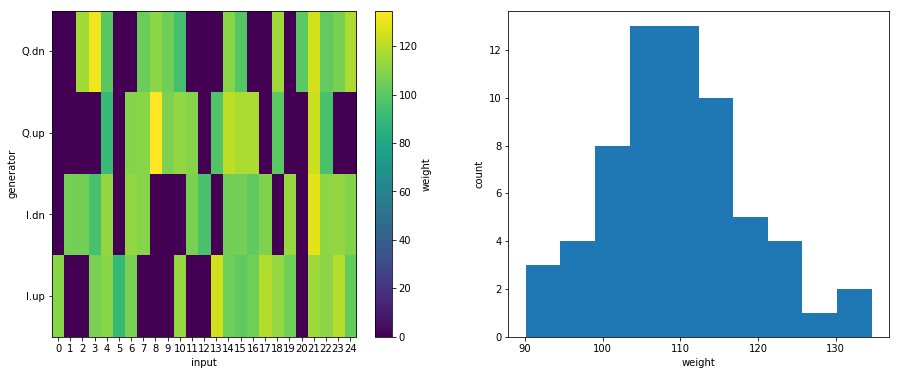

In [13]:
W = np.zeros((params['Ninp'], params['Ngen']))
W[connectivity['gen_inp']['j'], connectivity['gen_inp']['i']] = Wgen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
#ax2.scatter(connectivity['gen_inp']['j'], connectivity['gen_inp']['i'], c=Wgen)
im = ax1.imshow(W.T, interpolation='nearest', origin='low', aspect='auto',)
ax1.set_ylabel("generator")
ax1.set_yticks(np.arange(params['Ngen']))
ax1.set_yticklabels(params['gen_labels'])
ax1.set_xticks(np.arange(params['Ninp']))
ax1.set_xlabel("input")
fig.colorbar(im, ax=ax1, label="weight")
ax2.hist(Wgen)
ax2.set_xlabel("weight")
ax2.set_ylabel("count")

In [14]:
gInp = Neurons(params['Ninp'], equation_builder=DPI(num_inputs=2), refractory=0.0*ms, name='gInp')
gInp.Iahp = params['currents']['gInp']['Iahp']
gInp.Itau = params['currents']['gInp']['Itau']
gInp.Ispkthr = params['currents']['gInp']['Ispkthr']
sGenInp = Connections(components['generator'], gInp, equation_builder=DPISyn(), method='euler', name='sGenInp')
sGenInp.connect(i=connectivity['gen_inp']['i'], j=connectivity['gen_inp']['j'])
sGenInp.weight = connectivity['gen_inp']['w']
mInp = SpikeMonitor(gInp, name='mInp')
smInp = StateMonitor(gInp, ['Imem'], name='smInp', record=True)
components['layers']['gInp'] = gInp
components['synapsis']['sGenInp'] = sGenInp
components['monitors']['mInp'] = mInp
components['monitors']['smInp'] = smInp

In [15]:
components = setup_reservoir_layer(components, connectivity, params['N'], params['currents'], params['wInp'])
components['monitors']['smRes'] = StateMonitor(components['layers']['gRes'], ['Imem'], name='smRes', record=connectivity['inp_res']['j'])

In [16]:
network = init_network(components, indices, times)
defaultclock.dt = 50*us
duration = stimulation+settings['pause']*ms
network.run(duration)

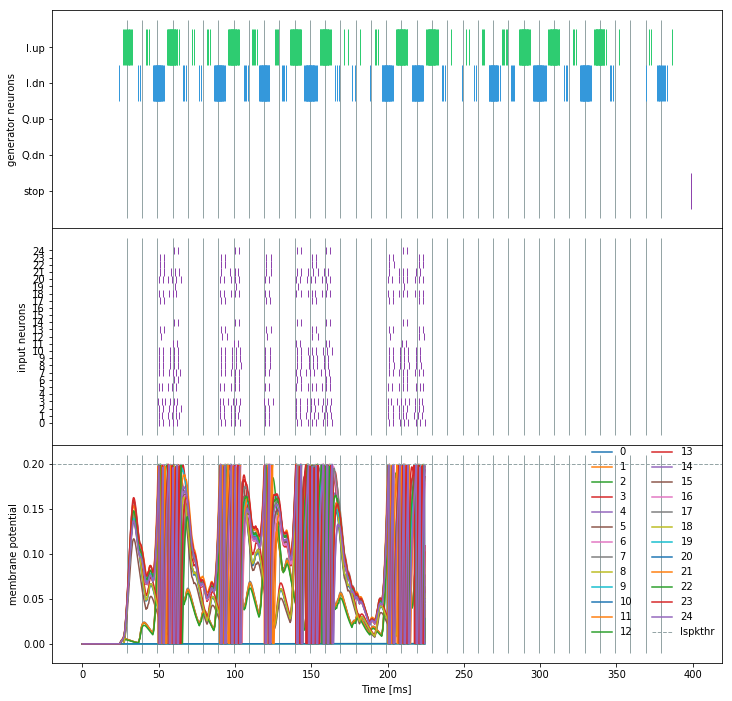

In [17]:
fig = plt.figure(figsize=(12, 12))
grid = grs.GridSpec(3, 1, wspace=0.0, hspace=0.0)
ax1 = plt.Subplot(fig, grid[0])
ax1.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5])
ax1.set_yticklabels(['stop', 'Q.dn', 'Q.up', 'I.dn', 'I.up'])
ax1.set_ylabel("generator neurons")
ax1.vlines(times[indices==0]/ms, ymin=3.0, ymax=4.0, colors='#2ecc71', linewidth=1)
ax1.vlines(times[indices==1]/ms, ymin=2.0, ymax=3.0, colors='#3498db', linewidth=1)
ax1.vlines(times[indices==2]/ms, ymin=1.0, ymax=2.0, colors='#e67e22', linewidth=1)
ax1.vlines(times[indices==3]/ms, ymin=0.0, ymax=1.0, colors='#e74c3c', linewidth=1)
ax1.vlines(times[indices==4]/ms, ymin=-1.0, ymax=0.0, colors='#8e44ad', linewidth=1)
ax1.vlines(bins/ms, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], colors="#95a5a6", linewidth=1, zorder=0)
ax2 = plt.Subplot(fig, grid[1], sharex=ax1)
ax2.set_yticks(np.arange(params['Ninp'])+0.5)
ax2.set_yticklabels(np.arange(params['Ninp']))
ax2.set_ylabel("input neurons")
for n in range(params['Ninp']):
    ax2.vlines(network['mInp'].t[network['mInp'].i==n]/ms, ymin=params['Ninp']-n-1, ymax=params['Ninp']-n, colors='#8e44ad', linewidth=1)
ax2.vlines(bins/ms, ymin=ax2.get_ylim()[0], ymax=ax2.get_ylim()[1], colors="#95a5a6", linewidth=1, zorder=0)
ax3 = plt.Subplot(fig, grid[2], sharex=ax1)
for n in range(params['Ninp']):
    ax3.plot(network['smInp'].t/ms, network['smInp'].Imem[n]/nA, label="{}".format(n))
ax3.vlines(bins/ms, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], colors="#95a5a6", linewidth=1, zorder=0)
ax3.axhline(network['gInp'].Ispkthr[0]/nA, linestyle='dashed', linewidth=1, color='#95a5a6', label="Ispkthr")
ax3.set_ylabel("membrane potential")
ax3.set_xlabel("Time [ms]")
ax3.legend(loc='lower left', bbox_to_anchor= (0.8, 0.1), ncol=2, borderaxespad=0, frameon=False)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
fig.add_subplot(ax3)

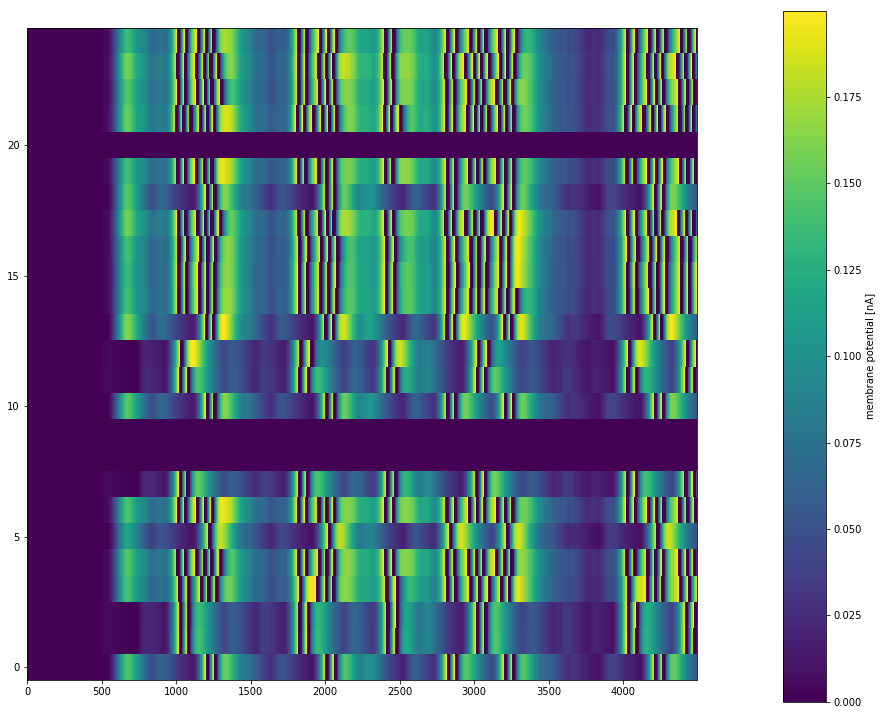

In [18]:
fig = plt.figure(figsize=(12, 12))
grid = grs.GridSpec(1, 1, wspace=0.0, hspace=0.0)
ax = plt.Subplot(fig, grid[0])
im = ax.imshow(network['smInp'].Imem/nA, interpolation='nearest', origin='low', aspect='auto')
ax_cbar1 = fig.add_axes([1, 0.1, 0.05, 0.8])
plt.colorbar(im, cax=ax_cbar1, orientation='vertical', label='membrane potential [nA]')
fig.add_subplot(ax)